**To be able to run this notebook you need to install the modified PennyLane version that contains the `qml.kernels` module via**
```
pip install git+https://www.github.com/johannesjmeyer/pennylane@kernel_module --upgrade
```

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import datasets

np.random.seed(42+1) # sorry, 42 did not build a nice dataset

# Define quantum circuit

In [3]:
def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding Ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])
        
    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])

@qml.template
def ansatz(x, params, wires):
    """The embedding Ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))
        
def random_params(num_wires, num_layers):
    return np.random.uniform(0, 2*np.pi, (num_layers, 2, num_wires))

In [4]:
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)

In [5]:
features = 2
width = 5
depth = 8 


dev = qml.device("default.qubit", wires=width)
wires = list(range(width))

# init the embedding kernel
k = qml.kernels.EmbeddingKernel(lambda x, params: ansatz(x, params, wires), dev)




In [6]:
dim = 4

init_false = False
init_true = False
for i in range(dim):
    for j in range(dim):
        pos_x = i
        pos_y = j
        data = (np.random.random((40,2))-0.5)/(2*dim)
        data[:,0] += (2*pos_x+1)/(2*dim)
        data[:,1] += (2*pos_y+1)/(2*dim)
        if (i%2 == 0 and j%2 == 0) or (i%2 == 1 and j%2 == 1):
            if init_false == False:
                false = data
                init_false = True
            else:
                false = np.vstack([false, data])
        else:
            if init_true == False:
                true = data
                init_true = True
            else:
                true = np.vstack([true, data])
print(false.shape)
print(true.shape)

(320, 2)
(320, 2)


# Define dataset

The training data is as follows:
The test data is as follows:


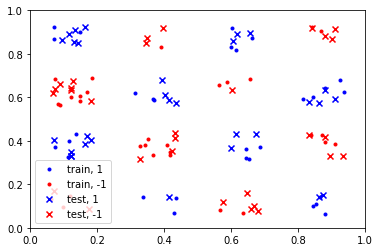

In [7]:
samples = 30 # number of samples to X_train[np.where(y=-1)], so total = 4*samples

np.random.shuffle(false)
np.random.shuffle(true)

X_train = np.vstack([false[:samples], true[:samples]])
y_train = np.hstack([-np.ones((samples)), np.ones((samples))])
X_test = np.vstack([false[samples:2*samples], true[samples:2*samples]])
y_test = np.hstack([-np.ones((samples)), np.ones((samples))])

print("The training data is as follows:")
plt.scatter(X_train[np.where(y_train == 1)[0],0], X_train[np.where(y_train == 1)[0],1], color="b", marker=".", label="train, 1")
plt.scatter(X_train[np.where(y_train == -1)[0],0], X_train[np.where(y_train == -1)[0],1], color="r", marker=".", label="train, -1")
print("The test data is as follows:")
plt.scatter(X_test[np.where(y_train == 1)[0],0], X_test[np.where(y_train == 1)[0],1], color="b", marker="x", label="test, 1")
plt.scatter(X_test[np.where(y_train == -1)[0],0], X_test[np.where(y_train == -1)[0],1], color="r", marker="x", label="test, -1")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.legend()

# Untrained Kernels

Loop that tests the accuracy on test set for an SVM

In [ ]:
acc_log = []
params_log = []
# evaluate the performance with random parameters for the kernel
## choose random params for the kernel
for i in range(3):
    params = random_params(width, depth)
    #print(params)
    ## fit the SVM on the training data
    svm_untrained_kernel = SVC(kernel=lambda X1, X2: k.kernel_matrix(X1, X2, params)).fit(X_train, y_train)
    ## evaluate on the test set
    untrained_accuracy = accuracy(svm_untrained_kernel, X_test, y_test)
    print("without kernel training accuracy", untrained_accuracy)
    acc_log.append(untrained_accuracy)
    params_log.append(params)
print("going with", acc_log[np.argmin(np.asarray(acc_log))])
params = params_log[np.argmin(np.asarray(acc_log))]

In [ ]:
print("Untrained accuracies:", acc_log)

In [ ]:
params = params_log[np.argmin(np.asarray(acc_log))]

In [ ]:
precision = 20 # higher is preciser and more compute time

# create a dummy dataset that uniformly spans the input space
X_dummy = []
for i in range(0,precision+1):
    for j in range(0,precision+1):
        X_dummy.append([i/precision,j/precision])
X_dummy = np.asarray(X_dummy)
print(len(X_dummy))

In [ ]:
# predict (about a minute on my laptop)
y_dummy_random_real = svm_untrained_kernel.decision_function(X_dummy)
y_dummy_random = np.sign(y_dummy_random_real)

In [ ]:
plotting =  True

In [ ]:
if plotting:
    # plot in order to observe the decision boundary
    plt.scatter(X_dummy[np.where(y_dummy_random == 1)[0],0], X_dummy[np.where(y_dummy_random == 1)[0],1], color="b", marker=".",label="dummy, 1")
    plt.scatter(X_dummy[np.where(y_dummy_random == -1)[0],0], X_dummy[np.where(y_dummy_random == -1)[0],1], color="r", marker=".",label="dummy, -1")
    plt.scatter(X_train[np.where(y_train == 1)[0],0], X_train[np.where(y_train == 1)[0],1], color="b", marker="+", label="train, 1")
    plt.scatter(X_train[np.where(y_train == -1)[0],0], X_train[np.where(y_train == -1)[0],1], color="r", marker="+", label="train, -1")
    plt.scatter(X_test[np.where(y_train == 1)[0],0], X_test[np.where(y_train == 1)[0],1], color="b", marker="x", label="test, 1")
    plt.scatter(X_test[np.where(y_train == -1)[0],0], X_test[np.where(y_train == -1)[0],1], color="r", marker="x", label="test, -1")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.legend()

In [ ]:
if plotting:
    plt.scatter(X_dummy[:,0], X_dummy[:,1], s=50, c = y_dummy_random_real, alpha=1, marker='s')

## save data

In [ ]:
filename = "dataset_checkerboard_random.npy"
with open(filename, 'wb') as f:
    np.save(f, X_dummy)
    np.save(f, y_dummy_random)
    np.save(f, y_dummy_random_real)
#    np.save(f, y_dummy)
#    np.save(f, y_dummy_real)
    np.save(f, X_train)
    np.save(f, y_train)
    np.save(f, X_test)
    np.save(f, y_test)
print('test')

In [ ]:
# evaluate the performance with trained parameters for the kernel
## train the kernel
alignment_log=[]
alignment = k.target_alignment(X_train, y_train, params)
alignment_log.append(alignment)
print("Step 0 - Alignment on train = {:.3f}".format(alignment))
opt = qml.GradientDescentOptimizer(2)
for i in range(1000):
    subset = np.random.choice(list(range(len(X_train))), 4)
    params = opt.step(lambda _params: -k.target_alignment(X_train[subset], y_train[subset], _params), params)
    
    if (i+1) % 50 == 0:
        alignment = k.target_alignment(X_train, y_train, params)
        alignment_log.append(alignment)
        print("Step {} - Alignment on train = {:.3f}".format(i+1, alignment))
## fit the SVM on the train set
svm_trained_kernel = SVC(kernel=lambda X1, X2: k.kernel_matrix(X1, X2, params)).fit(X_train, y_train)
## evaluate the accuracy on the test set
trained_accuracy = accuracy(svm_trained_kernel, X_test, y_test)
print("with kernel training accuracy on test", trained_accuracy)
# predict (about a minute on my laptop)
y_dummy_real = svm_trained_kernel.decision_function(X_dummy)
y_dummy = np.sign(y_dummy_real)

In [ ]:
if plotting:


    # plot in order to observe the decision boundary
    plt.scatter(X_dummy[np.where(y_dummy == 1)[0],0], X_dummy[np.where(y_dummy == 1)[0],1], color="b", marker=".",label="dummy, 1")
    plt.scatter(X_dummy[np.where(y_dummy == -1)[0],0], X_dummy[np.where(y_dummy == -1)[0],1], color="r", marker=".",label="dummy, -1")
    plt.scatter(X_train[np.where(y_train == 1)[0],0], X_train[np.where(y_train == 1)[0],1], color="b", marker="+", label="train, 1")
    plt.scatter(X_train[np.where(y_train == -1)[0],0], X_train[np.where(y_train == -1)[0],1], color="r", marker="+", label="train, -1")
    plt.scatter(X_test[np.where(y_test == 1)[0],0], X_test[np.where(y_test == 1)[0],1], color="b", marker="x", label="test, 1")
    plt.scatter(X_test[np.where(y_test == -1)[0],0], X_test[np.where(y_test == -1)[0],1], color="r", marker="x", label="test, -1")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.legend()
if plotting:
    plt.scatter(X_dummy[:,0], X_dummy[:,1], s=50, c = y_dummy_real, alpha=1, marker='s')

In [ ]:
filename = "dataset_checkerboard.npy"
with open(filename, 'wb') as f:
    np.save(f, X_dummy)
    np.save(f, y_dummy_random)
    np.save(f, y_dummy_random_real)
    np.save(f, y_dummy)
    np.save(f, y_dummy_real)
    np.save(f, X_train)
    np.save(f, y_train)
    np.save(f, X_test)
    np.save(f, y_test)

In [ ]:
# with open(filename, 'rb') as f:
#     X_dummy_c = np.load(f)
#     y_dummy__random_c = np.load(f)
#     y_dummy_random_real_c = np.load(f)
#     y_dummy_c = np.load(f)
#     y_dummy_real_c = np.load(f)
#     X_train_c = np.load(f)
#     y_train_c = np.load(f)
#     X_test_c = np.load(f)
#     y_test_c = np.load(f)
filename = "alignment_checkerboard.npy"
with open(filename, 'wb') as f:
    np.save(f, alignment_log)